In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset.zip -d /content/sample_data/Dataset1

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform=torchvision.transforms.Compose([
                              torchvision.transforms.Resize((128,128)),
                              torchvision.transforms.ToTensor(),
                              transforms.transforms.Normalize((0.5,), (0.5,))
                              ])
data_path="/content/sample_data/Dataset1"
dataset = datasets.ImageFolder(data_path, transform=transform)

n=len(dataset)
test_size=int(0.2*n)#Dataset divided  as 60(train)-20(val)-20(test)
train_size=n-2*test_size

train_set,val_set,test_set=torch.utils.data.random_split(dataset,
                                                 [train_size,test_size,test_size])

def load_data(batch_size):
  # Data loader
  train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                            batch_size=batch_size, 
                                            shuffle=True)

  val_loader=torch.utils.data.DataLoader(dataset=val_set,
                                        batch_size=batch_size,
                                        shuffle=False)

  test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                            batch_size=batch_size, 
                                            shuffle=False)
  
  return train_loader,val_loader,test_loader

In [ ]:
class ConvNet(nn.Module):
  def __init__(self,num_classes=15,is_residual=False,drop_out=0):
    super(ConvNet,self).__init__()
    #shape 256,256

    self.conv1=nn.Conv2d(in_channels=3,out_channels=4,kernel_size=3, stride=1,padding=1)
    self.bn1=nn.BatchNorm2d(4)
    self.relu1=nn.ReLU()

    self.conv2=nn.Conv2d(4,12,3,1,1)

    self.relu2=nn.ReLU()
    
    self.pool=nn.MaxPool2d(2,2)
    #shape 128,128

    self.conv3=nn.Conv2d(12,18,3,1,1)
    self.bn3=nn.BatchNorm2d(18)
    self.relu3=nn.ReLU()

    self.pool=nn.MaxPool2d(2,2)
    #shape 64,64
    self.conv4=nn.Conv2d(18,24,3,1,1)
    self.relu4=nn.ReLU()

    self.conv5=nn.Conv2d(24,32,3,1,1)
    self.bn5=nn.BatchNorm2d(32)
    self.relu5=nn.ReLU()

    self.dropout = nn.Dropout(drop_out)

    self.fc1=nn.Linear(32*32*32,400)
    self.fc2=nn.Linear(400,15)

  def forward(self,x,is_residual=False,drop_out=0):

    residual=x
    output=self.conv1(x)
    output=self.bn1(output)
    output=self.relu1(output)

    output=self.conv2(output)

    if is_residual:
      output+=residual

    output=self.relu2(output)

    output=self.pool(output)

    output=self.conv3(output)
    output=self.bn3(output)
    output=self.relu3(output)

    output=self.pool(output)

    if drop_out!=0 :
      output=self.dropout(output)

    output=self.conv4(output)
    output=self.relu4(output)

    output=self.conv5(output)
    output=self.bn5(output)
    output=self.relu5(output)

    if drop_out!=0 :
      output=self.dropout(output)

    output=output.view(-1,32*32*32)
    output=self.fc1(output)
    output=self.fc2(output)

    return output

In [ ]:
def plotting(x, y, y2, y3, label1="Train", label2="Loss",
             xlabel="Epoch", ylabel="Accuracy", title="title"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.plot(x, y, label=label1)
    ax1.plot(x,y2,label="Validation")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.legend()

    ax2.plot(x, y3, label=label2)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(label2)
    ax2.legend()
    plt.show()

In [ ]:
def train(train_loader,val_loader,num_epochs,optimizer,criterion):
  l=list()

  # Train the model
  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      n_correct = 0
      n_samples = 0
      for i, (images, labels) in enumerate(train_loader):  
        
          images=images.to(device)
          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)

          # max returns (value ,index)
          _, predicted = torch.max(outputs.data, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if (i+1) % len(train_loader) == 0:

              val_n_correct = 0
              val_n_samples = 0
              for val_img,val_labels in val_loader:
                  val_img=val_img.to(device)
                  val_labels = val_labels.to(device)

                  val_outputs = model(val_img)
                  # max returns (value ,index)
                  _, val_predicted = torch.max(val_outputs.data, 1)
                  val_n_samples += val_labels.size(0)
                  val_n_correct += (val_predicted == val_labels).sum().item()

              val_acc=100.0 * val_n_correct / val_n_samples
              acc = 100.0 * n_correct / n_samples
              l.append([epoch+1,acc,loss.item(),val_acc])
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
  return l


Epoch [1/30], Step [11/11], Loss: 26.4624
Epoch [2/30], Step [11/11], Loss: 9.1084
Epoch [3/30], Step [11/11], Loss: 4.2591
Epoch [4/30], Step [11/11], Loss: 2.5181
Epoch [5/30], Step [11/11], Loss: 1.8483
Epoch [6/30], Step [11/11], Loss: 1.4012
Epoch [7/30], Step [11/11], Loss: 0.9300
Epoch [8/30], Step [11/11], Loss: 0.5982
Epoch [9/30], Step [11/11], Loss: 0.4016
Epoch [10/30], Step [11/11], Loss: 0.3889
Epoch [11/30], Step [11/11], Loss: 0.2166
Epoch [12/30], Step [11/11], Loss: 0.2199
Epoch [13/30], Step [11/11], Loss: 0.1731
Epoch [14/30], Step [11/11], Loss: 0.1139
Epoch [15/30], Step [11/11], Loss: 0.0642
Epoch [16/30], Step [11/11], Loss: 0.0651
Epoch [17/30], Step [11/11], Loss: 0.0480
Epoch [18/30], Step [11/11], Loss: 0.0453
Epoch [19/30], Step [11/11], Loss: 0.0321
Epoch [20/30], Step [11/11], Loss: 0.0408
Epoch [21/30], Step [11/11], Loss: 0.0242
Epoch [22/30], Step [11/11], Loss: 0.0357
Epoch [23/30], Step [11/11], Loss: 0.0615
Epoch [24/30], Step [11/11], Loss: 0.0333


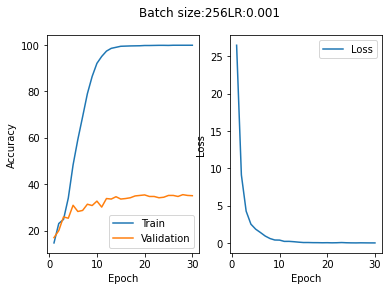

In [ ]:
import numpy as np
# Hyper-parameters 
batch_list=[256]#[256,128,64,32]
lr_list=[0.001]#[0.001,0.01,0.05,0.1]
is_residual_list=[False]#[False,True]
num_epochs = 30
for _boolean in is_residual_list:
  for b_size in batch_list:
    for learning_rate in lr_list:

      train_loader,val_loader,test_loader=load_data(b_size)
      model=ConvNet(is_residual=_boolean,drop_out=0.2).to(device)

      # Loss and optimizer
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
      l=train(train_loader,val_loader,num_epochs,optimizer,criterion)
      epo = np.array([i[0] for i in l])
      acc = np.array([i[1] for i in l])
      lo_ss = np.array([i[2] for i in l])
      val_acc = np.array([i[3] for i in l])
      plotting(epo, acc, val_acc, lo_ss, title="Batch size:"+str(b_size)+"LR:"+str(learning_rate))
import pickle
pickle.dump(model,open("model","wb"))

In [ ]:
import pathlib
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

root=pathlib.Path(data_path)
classes=sorted([j.name.split("/")[-1] for j in root.iterdir()])

y_pred=[]
y_true=[]

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct=[0 for i in range(15)]
    n_class_samples=[0 for i in range(15)]
    for images, labels in test_loader:

        images=images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.data.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())
        
        for i in range(len(labels)):
          label=labels[i]
          pred=predicted[i]
          if (label==pred):
            n_class_correct[label]+=1
          n_class_samples[label]+=1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {acc} %')
    print()


    for i in range(len(n_class_correct)):
      acc=100.0 * n_class_correct[i]/n_class_samples[i]
      print(f'Accuracy of {classes[i]} class sample: {acc}%')

Accuracy of the network on the 896 test images: 36.71875 %

Accuracy of airport_inside class sample: 47.014925373134325%
Accuracy of artstudio class sample: 8.0%
Accuracy of bakery class sample: 38.46153846153846%
Accuracy of bar class sample: 38.52459016393443%
Accuracy of bathroom class sample: 47.36842105263158%
Accuracy of bedroom class sample: 63.9344262295082%
Accuracy of bookstore class sample: 29.62962962962963%
Accuracy of bowling class sample: 24.324324324324323%
Accuracy of buffet class sample: 3.7037037037037037%
Accuracy of casino class sample: 37.07865168539326%
Accuracy of church_inside class sample: 15.789473684210526%
Accuracy of classroom class sample: 12.5%
Accuracy of closet class sample: 26.08695652173913%
Accuracy of clothingstore class sample: 12.5%
Accuracy of computerroom class sample: 6.896551724137931%


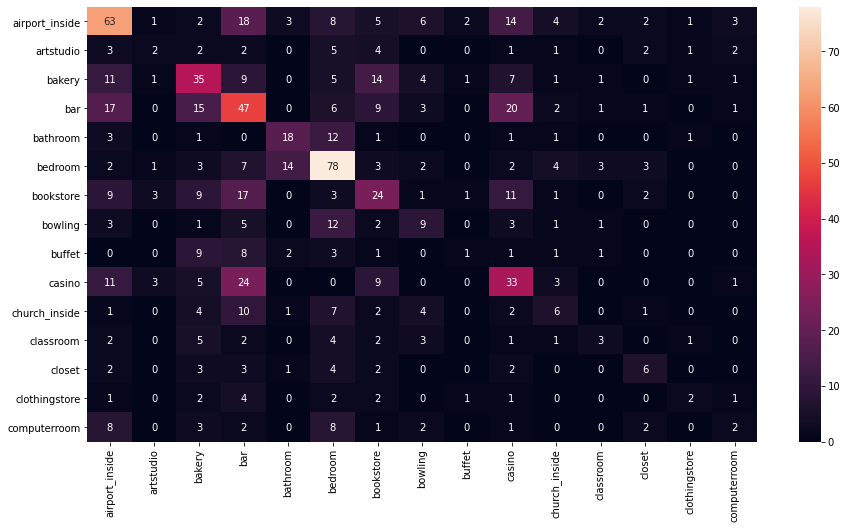

In [ ]:
import pandas as pd
import seaborn as sn
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (15,8))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')